In [1]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 04 03:40:52 2014

@author: shishir
@email: shishir.py@gmail.com
"""

#
#  tsne.py
#  
# Implementation of t-SNE in Python. The implementation was tested on Python 2.5.1, and it requires a working 
# installation of NumPy. The implementation comes with an example on the MNIST dataset. In order to plot the
# results of this example, a working installation of matplotlib is required.
# The example can be run by executing: ipython tsne.py -pylab
#
#
#  Created by Laurens van der Maaten on 20-12-08.
#  Copyright (c) 2008 Tilburg University. All rights reserved.

import numpy as Math
import pylab as Plot
import numpy as np
from matplotlib import pyplot as plt

def Hbeta(D = Math.array([]), beta = 1.0):
    """Compute the perplexity and the P-row for a specific value of the precision of a Gaussian distribution."""
    
    # Compute P-row and corresponding perplexity
    P = Math.exp(-D.copy() * beta);
    sumP = sum(P);
    H = Math.log(sumP) + beta * Math.sum(D * P) / sumP;
    P = P / sumP;
    return H, P;


def x2p(X = Math.array([]), tol = 1e-5, perplexity = 30.0):
    """Performs a binary search to get P-values in such a way that each conditional Gaussian has the same perplexity."""

    # Initialize some variables
    print "Computing pairwise distances..."
    (n, d) = X.shape;
    sum_X = Math.sum(Math.square(X), 1);
    D = Math.add(Math.add(-2 * Math.dot(X, X.T), sum_X).T, sum_X);
    P = Math.zeros((n, n));
    beta = Math.ones((n, 1));
    logU = Math.log(perplexity);

    # Loop over all datapoints
    for i in range(n):
        # Print progress
        if i % 1000 == 0:
            print "Computing P-values for point ", i, " of ", n, "..."

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -Math.inf; 
        betamax =  Math.inf;
        Di = D[i, Math.concatenate((Math.r_[0:i], Math.r_[i+1:n]))];
        (H, thisP) = Hbeta(Di, beta[i]);

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU;
        tries = 0;
        while Math.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i];
                if betamax == Math.inf or betamax == -Math.inf:
                    beta[i] = beta[i] * 2;
                else:
                    beta[i] = (beta[i] + betamax) / 2;
            else:
                betamax = beta[i];
                if betamin == Math.inf or betamin == -Math.inf:
                    beta[i] = beta[i] / 2;
                else:
                    beta[i] = (beta[i] + betamin) / 2;

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i]);
            Hdiff = H - logU;
            tries = tries + 1;

        # Set the final row of P
        P[i, Math.concatenate((Math.r_[0:i], Math.r_[i+1:n]))] = thisP;

    # Return final P-matrix
    print "Mean value of sigma: ", Math.mean(Math.sqrt(1 / beta))
    return P;


def pca(X = Math.array([]), no_dims = 50):
    """Runs PCA on the NxD array X in order to reduce its dimensionality to no_dims dimensions."""

    print "Preprocessing the data using PCA..."
    (n, d) = X.shape;
    X = X - Math.tile(Math.mean(X, 0), (n, 1));
    (l, M) = Math.linalg.eig(Math.dot(X.T, X));
    Y = Math.dot(X, M[:,0:no_dims]);
    return Y;
    

def tsne_renyi2_npca(X = Math.array([]), alpha = 0.5, no_dims = 2, initial_dims = 50, perplexity = 30.0, max_iter = 500,\
                    initial_momentum = 0.2, final_momentum = 0.5, eta = 500):
    """
    Runs t-SNE on the dataset in the NxD array X to reduce its 
    dimensionality to no_dims dimensions. The syntaxis of the function is 
    Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.

    Parameters
    -------------
    X: Data points (n_samples, n_features)

    no_dims: (default 2) The dimension of the space in which the data has
        to be embedded.

    initial_dims: (default 50) The dimenion on the PCA embedding space.

    perplexity: (default 30.0) Values between 5 and 50 shoulb be good.

    Return
    ------------
    Y: The embedding of the 
    """
    # Check inputs
    if X.dtype != "float64":
        print "Error: array X should have type float64.";
        return -1;
    #if no_dims.__class__ != "<type 'int'>":			# doesn't work yet!
    #	print "Error: number of dimensions should be an integer.";
    #	return -1;

    # Initialize variables
    #X = pca(X, initial_dims);

    alpha = alpha  #paramerter to be added
    
    
    (n, d) = X.shape;
    max_iter = max_iter;
#     initial_momentum = 0.5;
#     final_momentum = 0.8;

    initial_momentum = initial_momentum;
    final_momentum = final_momentum;
    
    eta = eta;
    min_gain = 0.001;
    Y = Math.random.randn(n, no_dims);
    dY = Math.zeros((n, no_dims));
    iY = Math.zeros((n, no_dims));
    gains = Math.ones((n, no_dims));

    # Compute P-values
    P = x2p(X, 1e-5, perplexity);
    P = P + Math.transpose(P);
    P = P / Math.sum(P);
    P = P * 4;  # early exaggeration
    P = Math.maximum(P, 1e-12);
    cost = []
    # Run iterations
    P_alpha = np.power(P, alpha)

    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = Math.sum(Math.square(Y), 1);
        num = 1 / (1 + Math.add(Math.add(-2 * Math.dot(Y, Y.T), sum_Y).T, sum_Y));
        num[range(n), range(n)] = 0;
        Q = num / Math.sum(num);
        Q = Math.maximum(Q, 1e-12);
        
        Q_alpha = np.power(Q, 1-alpha)
        
        T = np.sum(Q_alpha * P_alpha)
        
        PQ =   Q_alpha * P_alpha- T * Q
        
        
        # Compute gradient
        for i in range(n):
            dY[i,:] = 2 * Math.sum(Math.tile(PQ[:,i] * num[:,i], (no_dims, 1)).T * (Y[i,:] - Y), 0);
        
        """
        # This is what needs to be changed.
        PQ = P - Q;
        for i in range(n):
            dY[i,:] = Math.sum(Math.tile(PQ[:,i] * num[:,i], (no_dims, 1)).T * (Y[i,:] - Y), 0);
        """
        
        #Renyi divergence of order alpha
        
        #Renyi divergence of order 2
#        PP = np.square(P)/Q
#        
#        sumall = (1 + Math.add(Math.add(-2 * Math.dot(Y, Y.T), sum_Y).T, sum_Y))
#        sumall[range(n), range(n)] = 0
#        sum_num = np.dot(sumall.ravel(), np.square(P).ravel())
#        QQ = sum_num/sumall
#        
#        PQ = QQ - PP
#        
#        for i in range(n):
#            dY[i,:] = Math.sum(Math.tile(PQ[:,i] * num[:,i], (no_dims, 1)).T * (Y[i,:] - Y), 0);
#        
#        

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0) != (iY > 0)) + (gains * 0.8) * ((dY > 0) == (iY > 0));
        gains[gains < min_gain] = min_gain;
        iY = momentum * iY - eta * (gains * dY);
        Y = Y + iY;
        Y = Y - Math.tile(Math.mean(Y, 0), (n, 1));

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = T/(alpha - 1)
            print "Iteration ", (iter + 1), ": error is ", C
            cost.append(C)

        # Stop lying about P-values
        if iter == 100:
            P = P / 4;
        

    # Return solution
    return Y;

Run Y = tsne.tsne_renyi2_npca(X, alpha,  no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Computing pairwise distances...
Computing P-values for point  0  of  2500 ...
Computing P-values for point  1000  of  2500 ...
Computing P-values for point  2000  of  2500 ...
Mean value of sigma:  3.05994441329
Iteration  10 : error is  216.932574864
Iteration  20 : error is  216.924534744
Iteration  30 : error is  216.879445663
Iteration  40 : error is  216.774458294
Iteration  50 : error is  216.623124889
Iteration  60 : error is  216.430303608
Iteration  70 : error is  216.197850069
Iteration  80 : error is  215.926603125
Iteration  90 : error is  215.617077353
Iteration  100 : error is  215.269704302
Iteration  110 : error is  214.884916336
Iteration  120 : error is  214.463175523
Iteration  130 : error is  214.004983357
Iteration  140 : error is  213.510883792
Iteration  150 : error is  212.981463997
Iteration  160 : error is  212.417354308
Iter

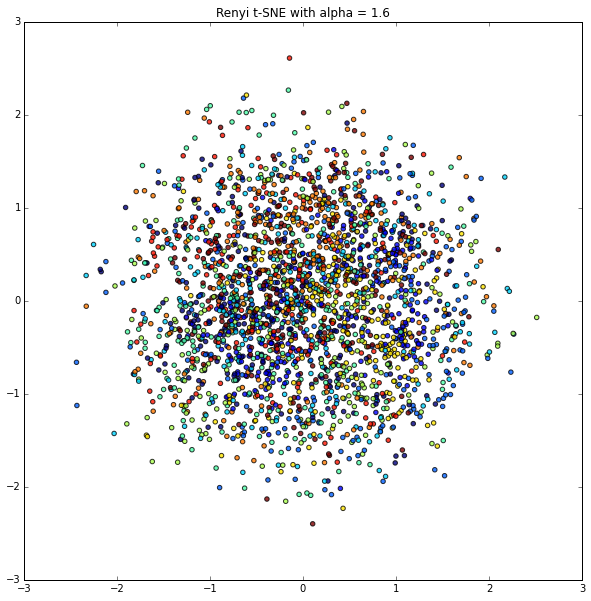

Computing pairwise distances...
Computing P-values for point  0  of  2500 ...
Computing P-values for point  1000  of  2500 ...
Computing P-values for point  2000  of  2500 ...
Mean value of sigma:  3.05994441329
Iteration  10 : error is  2128.49830353
Iteration  20 : error is  2124.40552695
Iteration  30 : error is  2101.76498659
Iteration  40 : error is  2051.13724218
Iteration  50 : error is  1983.30403412
Iteration  60 : error is  1905.05217309
Iteration  70 : error is  1821.39036682
Iteration  80 : error is  1736.17003648
Iteration  90 : error is  1652.27152707
Iteration  100 : error is  1571.7320591
Iteration  110 : error is  1495.90268484
Iteration  120 : error is  1425.60490199
Iteration  130 : error is  1361.25280139
Iteration  140 : error is  1302.95508189
Iteration  150 : error is  1250.58547867
Iteration  160 : error is  1203.83493943
Iteration  170 : error is  1162.26273084
Iteration  180 : error is  1125.34455129
Iteration  190 : error is  1092.52857671
Iteration  200 : er

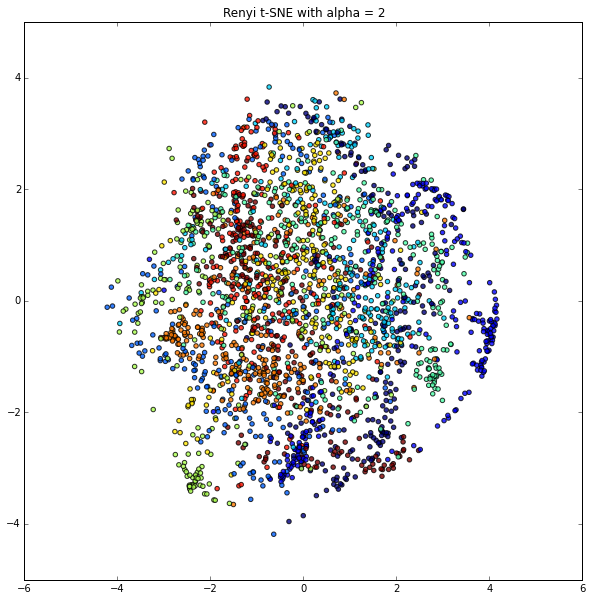

Computing pairwise distances...
Computing P-values for point  0  of  2500 ...
Computing P-values for point  1000  of  2500 ...
Computing P-values for point  2000  of  2500 ...
Mean value of sigma:  3.05994441329
Iteration  10 : error is  434584.629114
Iteration  20 : error is  249522.666593
Iteration  30 : error is  130970.187023
Iteration  40 : error is  90956.540766
Iteration  50 : error is  70167.2155768
Iteration  60 : error is  58757.600823
Iteration  70 : error is  51725.2793647
Iteration  80 : error is  46932.569482
Iteration  90 : error is  43449.7016831
Iteration  100 : error is  40503.4730831
Iteration  110 : error is  37566.6016282
Iteration  120 : error is  34524.4014612
Iteration  130 : error is  31415.5991417
Iteration  140 : error is  28500.849983
Iteration  150 : error is  25931.9731996
Iteration  160 : error is  23696.0011805
Iteration  170 : error is  21782.4358674
Iteration  180 : error is  20187.8658731
Iteration  190 : error is  18864.0758983
Iteration  200 : error

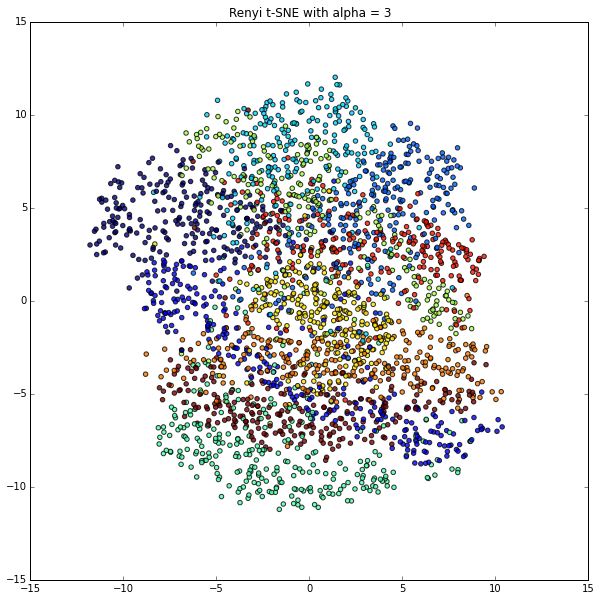

In [5]:
%matplotlib inline
print "Run Y = tsne.tsne_renyi2_npca(X, alpha,  no_dims, perplexity) to perform t-SNE on your dataset."
print "Running example on 2,500 MNIST digits..."
X = Math.loadtxt("mnist2500_pca_50.txt");
labels = Math.loadtxt("mnist2500_labels.txt");
#X = np.loadtxt('olivetti_pca_50.csv', delimiter = ',')

alphas = [1.6, 2, 3]
#alphas = [
#alpha = 0.5
for alpha in alphas:
    Y = tsne_renyi2_npca(X, alpha = alpha, max_iter=1000, initial_momentum= 0.1, final_momentum=0.9, eta = 0.0001)
    #Y = tsne(X, 2, 30, 20.0, max_iter = 200)

    print "\a"    

    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    ax.scatter(Y[:,0], Y[:,1], 20, labels, alpha = 0.8)
    ax.set_title('Renyi t-SNE with alpha = ' + str(alpha))
    plt.show()
    
    #np.savetxt('Digits_renyi_2d_' + str(alpha) + '_15000.txt', Y)

Run Y = tsne.tsne_renyi2_npca(X, alpha,  no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Computing pairwise distances...
Computing P-values for point  0  of  2500 ...
Computing P-values for point  1000  of  2500 ...
Computing P-values for point  2000  of  2500 ...
Mean value of sigma:  3.05994441329
Iteration  10 : error is  218.796030527
Iteration  20 : error is  218.788096219
Iteration  30 : error is  218.743630165
Iteration  40 : error is  218.640124237
Iteration  50 : error is  218.490969914
Iteration  60 : error is  218.30097616
Iteration  70 : error is  218.071989437
Iteration  80 : error is  217.804854486
Iteration  90 : error is  217.500097914
Iteration  100 : error is  217.158166135
Iteration  110 : error is  216.779507785
Iteration  120 : error is  216.364601813
Iteration  130 : error is  215.91396662
Iteration  140 : error is  215.428162525
Iteration  150 : error is  214.907791906
Iteration  160 : error is  214.353498513
Iterat

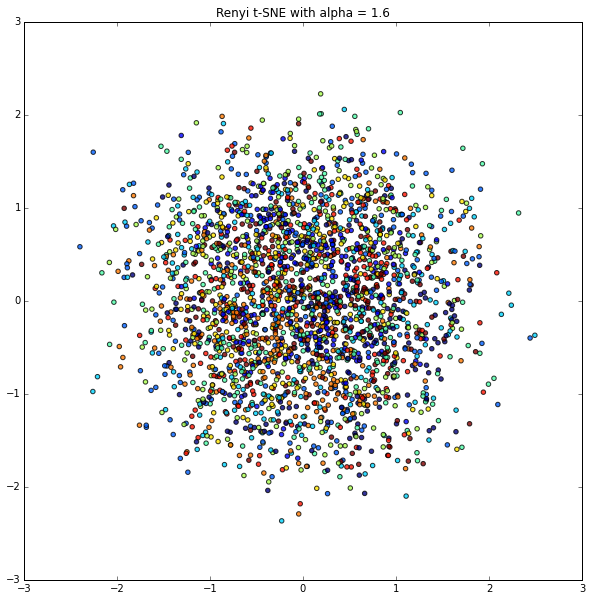

Computing pairwise distances...
Computing P-values for point  0  of  2500 ...
Computing P-values for point  1000  of  2500 ...
Computing P-values for point  2000  of  2500 ...
Mean value of sigma:  3.05994441329
Iteration  10 : error is  2124.7949677
Iteration  20 : error is  2120.30560829
Iteration  30 : error is  2095.55440802
Iteration  40 : error is  2040.53344984
Iteration  50 : error is  1967.54733251
Iteration  60 : error is  1884.43778611
Iteration  70 : error is  1796.90634597
Iteration  80 : error is  1709.17266742
Iteration  90 : error is  1624.20310582
Iteration  100 : error is  1543.89625914
Iteration  110 : error is  1469.29493707
Iteration  120 : error is  1400.82195507
Iteration  130 : error is  1338.50544724
Iteration  140 : error is  1282.14609848
Iteration  150 : error is  1231.4213639
Iteration  160 : error is  1185.94810589
Iteration  170 : error is  1145.29897325
Iteration  180 : error is  1109.01160263
Iteration  190 : error is  1076.60714183
Iteration  200 : err

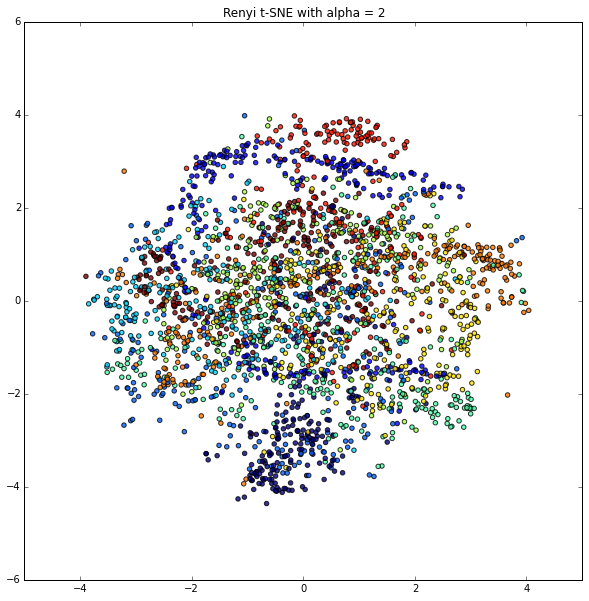

Computing pairwise distances...
Computing P-values for point  0  of  2500 ...
Computing P-values for point  1000  of  2500 ...
Computing P-values for point  2000  of  2500 ...
Mean value of sigma:  3.05994441329
Iteration  10 : error is  437081.702731
Iteration  20 : error is  254278.478291
Iteration  30 : error is  131923.108999
Iteration  40 : error is  89623.4832264
Iteration  50 : error is  69349.3972812
Iteration  60 : error is  57981.4248012
Iteration  70 : error is  50863.2959429
Iteration  80 : error is  46225.3100116
Iteration  90 : error is  42805.5122471
Iteration  100 : error is  39847.1426432
Iteration  110 : error is  36830.6167547
Iteration  120 : error is  33681.6004279
Iteration  130 : error is  30484.5324258
Iteration  140 : error is  27480.7531141
Iteration  150 : error is  24810.4370346
Iteration  160 : error is  22506.9856573
Iteration  170 : error is  20550.3825806
Iteration  180 : error is  18894.2138496
Iteration  190 : error is  17483.2163312
Iteration  200 : e

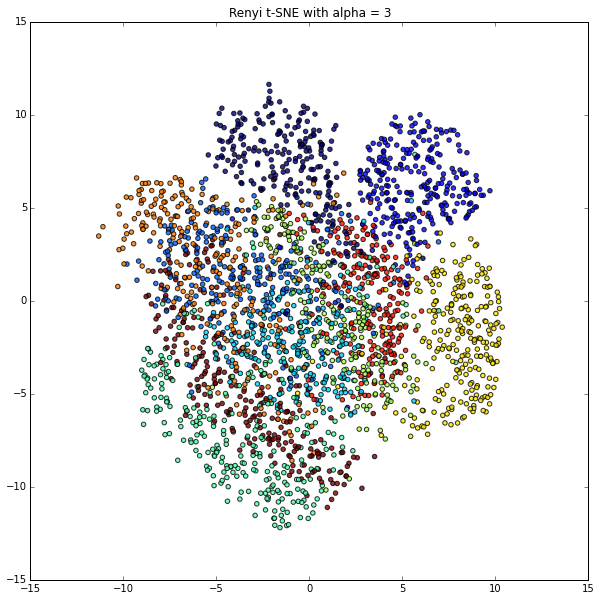

In [9]:
%matplotlib inline
print "Run Y = tsne.tsne_renyi2_npca(X, alpha,  no_dims, perplexity) to perform t-SNE on your dataset."
print "Running example on 2,500 MNIST digits..."
X = Math.loadtxt("mnist2500_pca_50.txt");
labels = Math.loadtxt("mnist2500_labels.txt");
#X = np.loadtxt('olivetti_pca_50.csv', delimiter = ',')

alphas = [1.6, 2, 3]
#alphas = [
#alpha = 0.5
np.random.seed(1)
for alpha in alphas:
    Y = tsne_renyi2_npca(X, alpha = alpha, max_iter=1000, initial_momentum= 0.1, final_momentum=0.9, eta = 0.0001)
    #Y = tsne(X, 2, 30, 20.0, max_iter = 200)

    print "\a"    

    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    ax.scatter(Y[:,0], Y[:,1], 20, labels, alpha = 0.8)
    ax.set_title('Renyi t-SNE with alpha = ' + str(alpha))
    plt.show()
    
    np.savetxt('Digits_renyi_2d_seed_1_' + str(alpha) + '_1000.txt', Y)

Run Y = tsne.tsne_renyi2_npca(X, alpha,  no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Computing pairwise distances...
Computing P-values for point  0  of  2500 ...
Computing P-values for point  1000  of  2500 ...
Computing P-values for point  2000  of  2500 ...
Mean value of sigma:  3.05994441329
Iteration  10 : error is  126.937950085
Iteration  20 : error is  86.9768689543
Iteration  30 : error is  55.8222378358
Iteration  40 : error is  49.4213098552
Iteration  50 : error is  47.5404908387
Iteration  60 : error is  46.4360332233
Iteration  70 : error is  45.8558141766
Iteration  80 : error is  45.4889156888
Iteration  90 : error is  45.2189796144
Iteration  100 : error is  44.9679092112
Iteration  110 : error is  44.7072658948
Iteration  120 : error is  44.4398371623
Iteration  130 : error is  44.165837862
Iteration  140 : error is  43.8762352671
Iteration  150 : error is  43.5945790386
Iteration  160 : error is  43.2754278514
Itera

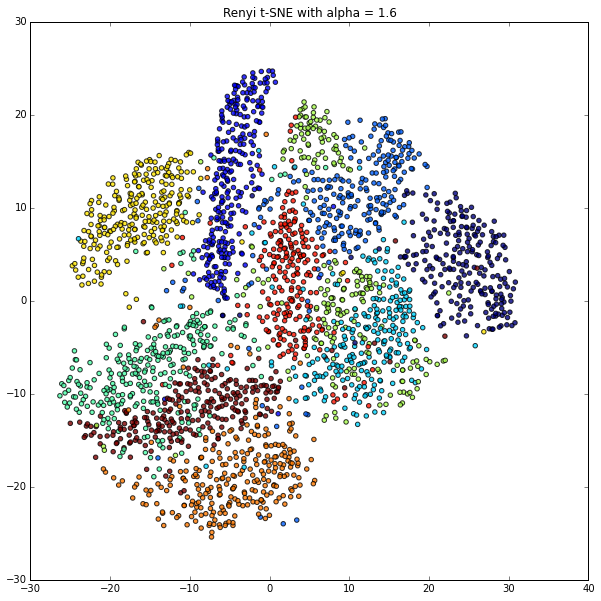

Computing pairwise distances...
Computing P-values for point  0  of  2500 ...
Computing P-values for point  1000  of  2500 ...
Computing P-values for point  2000  of  2500 ...
Mean value of sigma:  3.05994441329
Iteration  10 : error is  4215.88867041
Iteration  20 : error is  3321.81815427
Iteration  30 : error is  2809.56790796
Iteration  40 : error is  2971.86054564
Iteration  50 : error is  3484.44640381
Iteration  60 : error is  5124.37607972
Iteration  70 : error is  8580.36840375
Iteration  80 : error is  13637.1248714
Iteration  90 : error is  32077.2056992
Iteration  100 : error is  109668.705585
Iteration  110 : error is  2532542.8058
Iteration  120 : error is  13178581.0028
Iteration  130 : error is  6540118.88536
Iteration  140 : error is  6392815.88678
Iteration  150 : error is  6022980.53179
Iteration  160 : error is  5498724.81339
Iteration  170 : error is  5632040.9263
Iteration  180 : error is  5377321.80507
Iteration  190 : error is  5232672.36099
Iteration  200 : err

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:169: RuntimeWarning: divide by zero encountered in divide


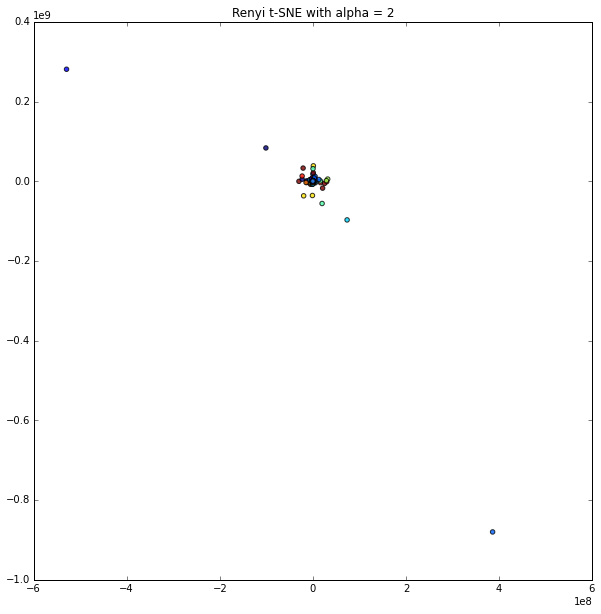

Computing pairwise distances...
Computing P-values for point  0  of  2500 ...
Computing P-values for point  1000  of  2500 ...
Computing P-values for point  2000  of  2500 ...
Mean value of sigma:  3.05994441329
Iteration  10 : error is  1.48962057124e+15
Iteration  20 : error is  1.27870307196e+15
Iteration  30 : error is  1.17450350959e+15
Iteration  40 : error is  1.17491150346e+15
Iteration  50 : error is  1.0316342373e+15
Iteration  60 : error is  9.17970576403e+14
Iteration  70 : error is  8.50939677118e+14
Iteration  80 : error is  8.11629127604e+14
Iteration  90 : error is  7.81514080877e+14
Iteration  100 : error is  7.71188205892e+14
Iteration  110 : error is  7.67680509798e+14
Iteration  120 : error is  7.47348887826e+14
Iteration  130 : error is  7.39828098532e+14
Iteration  140 : error is  7.33405164196e+14
Iteration  150 : error is  7.2779248146e+14
Iteration  160 : error is  7.22424615003e+14
Iteration  170 : error is  7.16298823635e+14
Iteration  180 : error is  7.09913

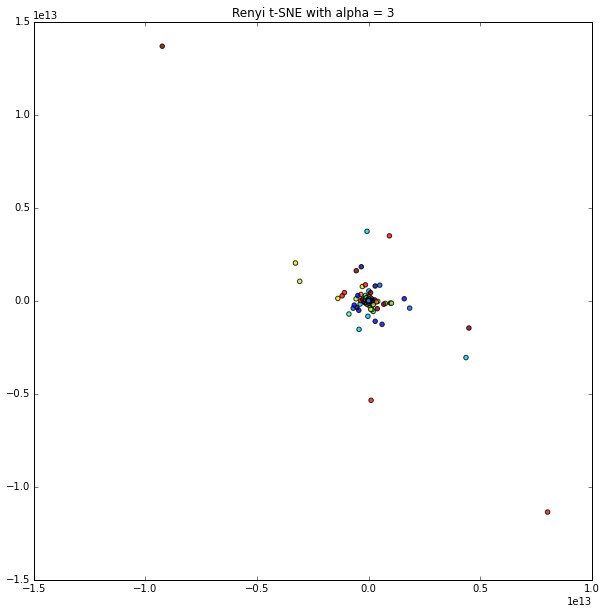

In [10]:
%matplotlib inline
print "Run Y = tsne.tsne_renyi2_npca(X, alpha,  no_dims, perplexity) to perform t-SNE on your dataset."
print "Running example on 2,500 MNIST digits..."
X = Math.loadtxt("mnist2500_pca_50.txt");
labels = Math.loadtxt("mnist2500_labels.txt");
#X = np.loadtxt('olivetti_pca_50.csv', delimiter = ',')

alphas = [1.6, 2, 3]
#alphas = [
#alpha = 0.5
np.random.seed(1)
for alpha in alphas:
    Y = tsne_renyi2_npca(X, alpha = alpha, max_iter=1000, initial_momentum= 0.1, final_momentum=0.9, eta = 10)
    #Y = tsne(X, 2, 30, 20.0, max_iter = 200)

    print "\a"    

    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    ax.scatter(Y[:,0], Y[:,1], 20, labels, alpha = 0.8)
    ax.set_title('Renyi t-SNE with alpha = ' + str(alpha))
    plt.show()
    
    np.savetxt('Digits_renyi_2d_seed_1_eta_10' + str(alpha) + '_1000.txt', Y)

In [7]:
##np.savetxt('Digits_renyi_2d_3_10000.txt', Y)

In [9]:
from sklearn.manifold import TSNE
from sklearn.manifold import t_sne

In [11]:
t_sne.trustworthiness(X, Y)

0.86677627608346708

## COIL-20 Dataset

Run Y = tsne.tsne_renyi2_npca(X, alpha,  no_dims, perplexity) to perform t-SNE on your dataset.
Running COIL Dataset
Computing pairwise distances...
Computing P-values for point  0  of  1440 ...
Computing P-values for point  1000  of  1440 ...
Mean value of sigma:  12.0305226823
Iteration  10 : error is  39.9763444716
Iteration  20 : error is  30.7373218053
Iteration  30 : error is  26.9704624245
Iteration  40 : error is  25.3258012788
Iteration  50 : error is  24.5206810719
Iteration  60 : error is  23.8624605289
Iteration  70 : error is  23.3580612185
Iteration  80 : error is  23.0550398568
Iteration  90 : error is  22.8337015584
Iteration  100 : error is  22.6581901091
Iteration  110 : error is  22.5096835369
Iteration  120 : error is  22.3607222515
Iteration  130 : error is  22.1837920048
Iteration  140 : error is  22.0800773286
Iteration  150 : error is  21.9908200668
Iteration  160 : error is  21.8954159107
Iteration  170 : error is  21.7908674462
Iteration  180 : error is  21.64

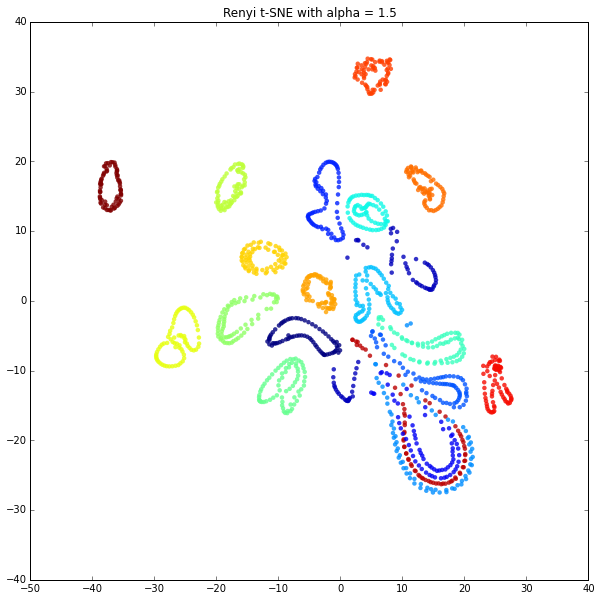

Computing pairwise distances...
Computing P-values for point  0  of  1440 ...
Computing P-values for point  1000  of  1440 ...
Mean value of sigma:  12.0305226823
Iteration  10 : error is  46.369507103
Iteration  20 : error is  35.3209818394
Iteration  30 : error is  29.0850295977
Iteration  40 : error is  26.6063349532
Iteration  50 : error is  25.2507859178
Iteration  60 : error is  24.501365005
Iteration  70 : error is  23.9119836125
Iteration  80 : error is  23.4358007653
Iteration  90 : error is  23.0783234506
Iteration  100 : error is  22.6499751385
Iteration  110 : error is  22.373082454
Iteration  120 : error is  22.1600919137
Iteration  130 : error is  21.9436597233
Iteration  140 : error is  21.6710529766
Iteration  150 : error is  21.4583616473
Iteration  160 : error is  21.3227577269
Iteration  170 : error is  21.2021095145
Iteration  180 : error is  21.0925969462
Iteration  190 : error is  20.9892500882
Iteration  200 : error is  20.9149470327
Iteration  210 : error is  20

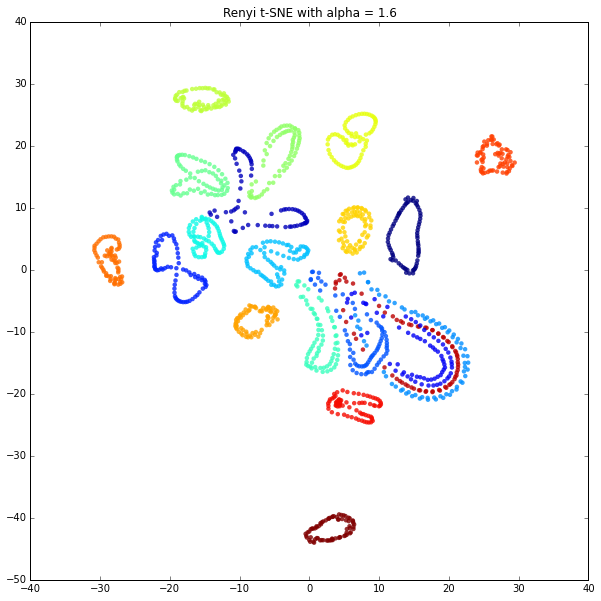

Computing pairwise distances...
Computing P-values for point  0  of  1440 ...
Computing P-values for point  1000  of  1440 ...
Mean value of sigma:  12.0305226823
Iteration  10 : error is  107.789419286
Iteration  20 : error is  54.3061316631
Iteration  30 : error is  36.4479017115
Iteration  40 : error is  32.3790049776
Iteration  50 : error is  29.6715434173
Iteration  60 : error is  28.0030512015
Iteration  70 : error is  26.7837233421
Iteration  80 : error is  26.163065767
Iteration  90 : error is  25.8198487434
Iteration  100 : error is  25.5607912478
Iteration  110 : error is  25.3554365273
Iteration  120 : error is  25.1929140666
Iteration  130 : error is  25.0318935833
Iteration  140 : error is  24.8164937207
Iteration  150 : error is  24.6527903555
Iteration  160 : error is  24.4913342254
Iteration  170 : error is  24.3098991955
Iteration  180 : error is  24.1327884625
Iteration  190 : error is  23.9614029138
Iteration  200 : error is  23.8393602425
Iteration  210 : error is  

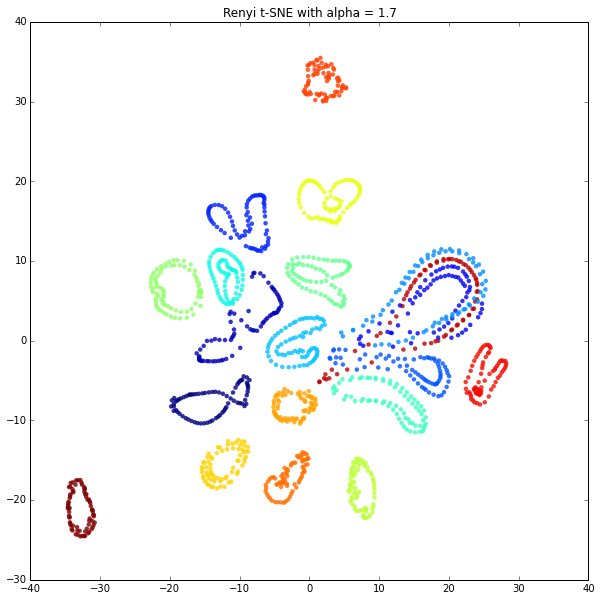

Computing pairwise distances...
Computing P-values for point  0  of  1440 ...
Computing P-values for point  1000  of  1440 ...
Mean value of sigma:  12.0305226823
Iteration  10 : error is  5658551.78107
Iteration  20 : error is  7536541.48052
Iteration  30 : error is  10104465.588
Iteration  40 : error is  7051895.09325
Iteration  50 : error is  6725996.15011
Iteration  60 : error is  6584930.24541
Iteration  70 : error is  6487955.47902
Iteration  80 : error is  6347474.40564
Iteration  90 : error is  6977998.35101
Iteration  100 : error is  6785848.81174
Iteration  110 : error is  6663075.22685
Iteration  120 : error is  6491126.31662
Iteration  130 : error is  6382681.00684
Iteration  140 : error is  6252928.89684
Iteration  150 : error is  6122396.6914
Iteration  160 : error is  6004583.3639
Iteration  170 : error is  5898638.69308
Iteration  180 : error is  5795624.12813
Iteration  190 : error is  5688239.35058
Iteration  200 : error is  5570934.50561
Iteration  210 : error is  54

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:169: RuntimeWarning: divide by zero encountered in divide


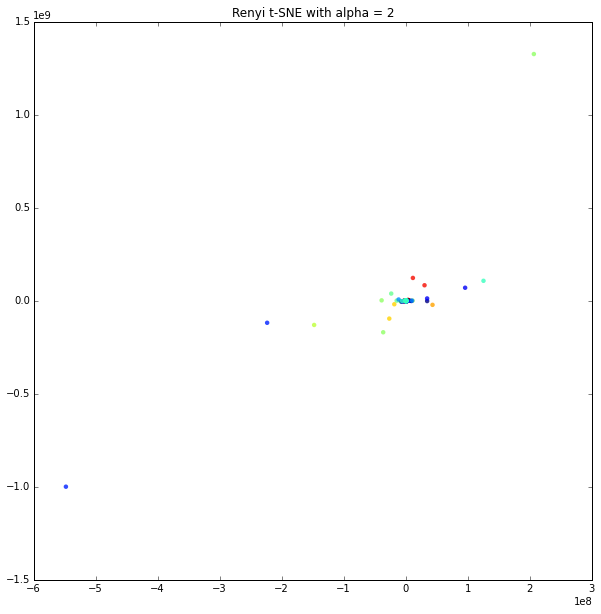

Computing pairwise distances...
Computing P-values for point  0  of  1440 ...
Computing P-values for point  1000  of  1440 ...
Mean value of sigma:  12.0305226823
Iteration  10 : error is  2.76839942755e+15
Iteration  20 : error is  2.07475917009e+15
Iteration  30 : error is  1.92588575122e+15
Iteration  40 : error is  1.85658600782e+15
Iteration  50 : error is  1.81098464013e+15
Iteration  60 : error is  1.75961800537e+15
Iteration  70 : error is  1.72373525881e+15
Iteration  80 : error is  1.67927222731e+15
Iteration  90 : error is  1.60070142426e+15
Iteration  100 : error is  1.52575959538e+15
Iteration  110 : error is  1.45690455593e+15
Iteration  120 : error is  1.39512764505e+15
Iteration  130 : error is  1.33593658768e+15
Iteration  140 : error is  1.28708481555e+15
Iteration  150 : error is  1.23873109287e+15
Iteration  160 : error is  1.1982660376e+15
Iteration  170 : error is  1.16420411938e+15
Iteration  180 : error is  1.12737039627e+15
Iteration  190 : error is  1.08858380

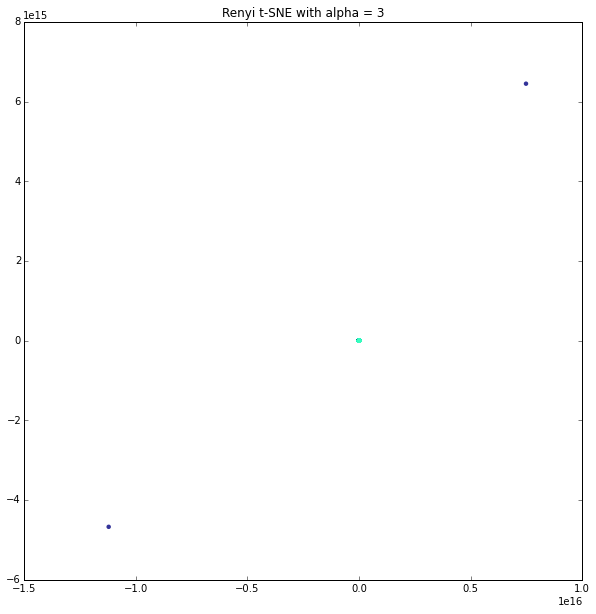

In [15]:
print "Run Y = tsne.tsne_renyi2_npca(X, alpha,  no_dims, perplexity) to perform t-SNE on your dataset."
print "Running COIL Dataset"

X = np.loadtxt('COIL-20_pca_50.txt')
labels = np.loadtxt('COIL-20_labels.txt')

#X = np.loadtxt('olivetti_pca_50.csv', delimiter = ',')

#alphas = [0.1, 0.2, 0.5, 0.7, 0.9, 0.95, 1.05, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6]
alphas = [1.5, 1.6, 1.7, 2, 3]
#alpha = 0.5
for alpha in alphas:
    max_iter = 500
    Y = tsne_renyi2_npca(X, alpha = alpha, no_dims=2, max_iter= max_iter, eta= 100)
    #Y = tsne(X, 2, 30, 20.0, max_iter = 200)

    fname = 'COIL_renyi_2d_' + str(alpha) +  '_' + str(max_iter) + '.txt'
    np.savetxt(fname, Y)

    print "\a"    

    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    ax.scatter(Y[:,0], Y[:,1], 20, labels, edgecolor = 'none',  alpha = 0.8)
    ax.set_title('Renyi t-SNE with alpha = ' + str(alpha))
    plt.show()

Run Y = tsne.tsne_renyi2_npca(X, alpha,  no_dims, perplexity) to perform t-SNE on your dataset.
Running COIL Dataset
Computing pairwise distances...
Computing P-values for point  0  of  1440 ...
Computing P-values for point  1000  of  1440 ...
Mean value of sigma:  12.0305226823
Iteration  10 : error is  293.758415523
Iteration  20 : error is  152.40371989
Iteration  30 : error is  97.3136655623
Iteration  40 : error is  77.0031528414
Iteration  50 : error is  66.8532171755
Iteration  60 : error is  60.3338157411
Iteration  70 : error is  55.9489888951
Iteration  80 : error is  52.8025814297
Iteration  90 : error is  50.3575732954
Iteration  100 : error is  48.3418558498
Iteration  110 : error is  46.6290464286
Iteration  120 : error is  45.1339763009
Iteration  130 : error is  43.8605857141
Iteration  140 : error is  42.8714202578
Iteration  150 : error is  42.0791449061
Iteration  160 : error is  41.3856931487
Iteration  170 : error is  40.7433619339
Iteration  180 : error is  40.033

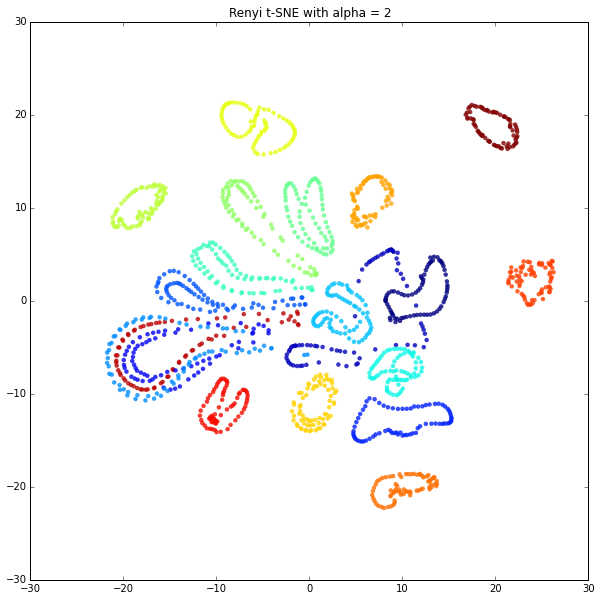

Computing pairwise distances...
Computing P-values for point  0  of  1440 ...
Computing P-values for point  1000  of  1440 ...
Mean value of sigma:  12.0305226823
Iteration  10 : error is  4.02893134781e+15
Iteration  20 : error is  3.59719341987e+15
Iteration  30 : error is  3.29640386212e+15
Iteration  40 : error is  3.10730467823e+15
Iteration  50 : error is  2.96665457461e+15
Iteration  60 : error is  2.85737117013e+15
Iteration  70 : error is  2.75602278118e+15
Iteration  80 : error is  2.67198552509e+15
Iteration  90 : error is  2.60674394387e+15
Iteration  100 : error is  2.55203988796e+15
Iteration  110 : error is  2.49208423256e+15
Iteration  120 : error is  2.4152159794e+15
Iteration  130 : error is  2.34316777998e+15
Iteration  140 : error is  2.28126815639e+15
Iteration  150 : error is  2.21886124285e+15
Iteration  160 : error is  2.1617108416e+15
Iteration  170 : error is  2.11324658237e+15
Iteration  180 : error is  2.07023443364e+15
Iteration  190 : error is  2.032044462

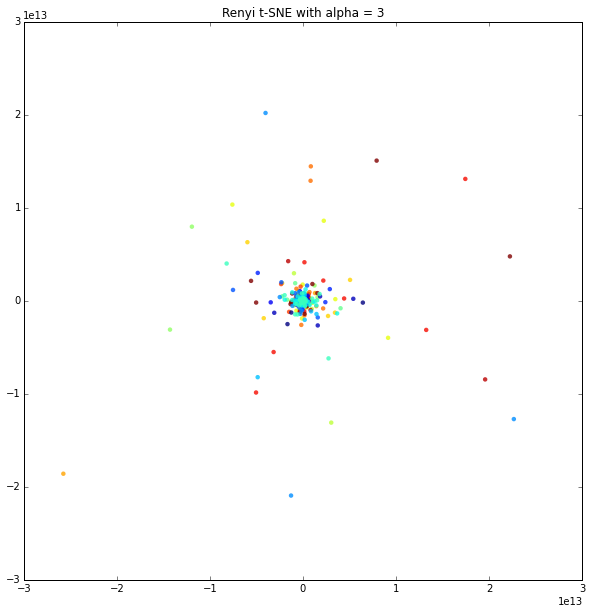

In [17]:
print "Run Y = tsne.tsne_renyi2_npca(X, alpha,  no_dims, perplexity) to perform t-SNE on your dataset."
print "Running COIL Dataset"

X = np.loadtxt('COIL-20_pca_50.txt')
labels = np.loadtxt('COIL-20_labels.txt')

#X = np.loadtxt('olivetti_pca_50.csv', delimiter = ',')

#alphas = [0.1, 0.2, 0.5, 0.7, 0.9, 0.95, 1.05, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6]
alphas = [2, 3]
#alpha = 0.5
for alpha in alphas:
    max_iter = 500
    Y = tsne_renyi2_npca(X, alpha = alpha, no_dims=2, max_iter= max_iter, eta= 1)
    #Y = tsne(X, 2, 30, 20.0, max_iter = 200)

    fname = 'COIL_renyi_2d_' + str(alpha) +  '_' + str(max_iter) + '.txt'
    np.savetxt(fname, Y)

    print "\a"    

    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    ax.scatter(Y[:,0], Y[:,1], 20, labels, edgecolor = 'none',  alpha = 0.8)
    ax.set_title('Renyi t-SNE with alpha = ' + str(alpha))
    plt.show()

Run Y = tsne.tsne_renyi2_npca(X, alpha,  no_dims, perplexity) to perform t-SNE on your dataset.
Running COIL Dataset
Computing pairwise distances...
Computing P-values for point  0  of  1440 ...
Computing P-values for point  1000  of  1440 ...
Mean value of sigma:  12.0305226823
Iteration  10 : error is  192865.879846
Iteration  20 : error is  105734.191309
Iteration  30 : error is  57653.4042083
Iteration  40 : error is  38857.6248265
Iteration  50 : error is  28997.3106736
Iteration  60 : error is  22820.8441777
Iteration  70 : error is  18622.6777637
Iteration  80 : error is  15616.5410721
Iteration  90 : error is  13388.8197084
Iteration  100 : error is  11690.6250833
Iteration  110 : error is  10360.6995546
Iteration  120 : error is  9293.10614429
Iteration  130 : error is  8416.60505751
Iteration  140 : error is  7682.61584978
Iteration  150 : error is  7057.79205932
Iteration  160 : error is  6519.03928594
Iteration  170 : error is  6050.15343514
Iteration  180 : error is  5639.

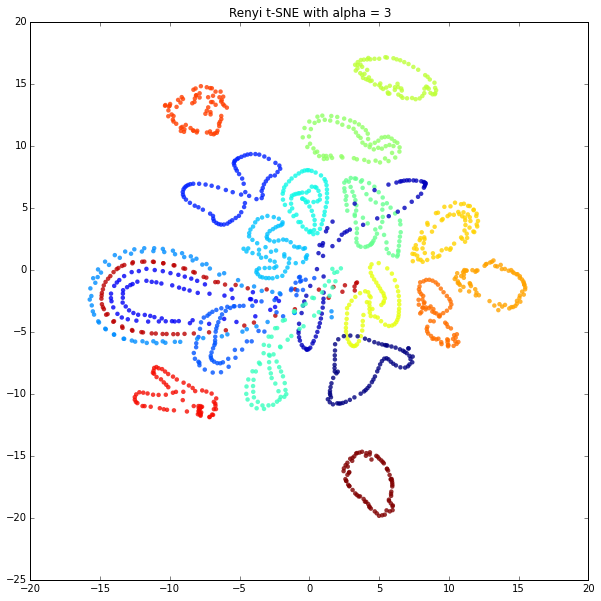

In [23]:
print "Run Y = tsne.tsne_renyi2_npca(X, alpha,  no_dims, perplexity) to perform t-SNE on your dataset."
print "Running COIL Dataset"

X = np.loadtxt('COIL-20_pca_50.txt')
labels = np.loadtxt('COIL-20_labels.txt')

#X = np.loadtxt('olivetti_pca_50.csv', delimiter = ',')

#alphas = [0.1, 0.2, 0.5, 0.7, 0.9, 0.95, 1.05, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6]
alphas = [3]
#alpha = 0.5
for alpha in alphas:
    max_iter = 5000
    Y = tsne_renyi2_npca(X, alpha = alpha, no_dims=2, max_iter= max_iter, eta= 0.0001)
    #Y = tsne(X, 2, 30, 20.0, max_iter = 200)

    fname = 'COIL_renyi_2d_' + str(alpha) +  '_' + str(max_iter) + '.txt'
    np.savetxt(fname, Y)

    print "\a"    

    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    ax.scatter(Y[:,0], Y[:,1], 20, labels, edgecolor = 'none',  alpha = 0.8)
    ax.set_title('Renyi t-SNE with alpha = ' + str(alpha))
    plt.show()

Run Y = tsne.tsne_renyi2_npca(X, alpha,  no_dims, perplexity) to perform t-SNE on your dataset.
Running COIL Dataset
Computing pairwise distances...
Computing P-values for point  0  of  1440 ...
Computing P-values for point  1000  of  1440 ...
Mean value of sigma:  12.0305226823
Iteration  10 : error is  2.67694296945e+14
Iteration  20 : error is  8.42936488179e+14
Iteration  30 : error is  6.63293952567e+14
Iteration  40 : error is  5.19401861197e+14
Iteration  50 : error is  4.89871174166e+14
Iteration  60 : error is  4.78600357318e+14
Iteration  70 : error is  4.6836488283e+14
Iteration  80 : error is  4.59616515035e+14
Iteration  90 : error is  4.52530442887e+14
Iteration  100 : error is  4.46903312095e+14
Iteration  110 : error is  4.40516197148e+14
Iteration  120 : error is  4.33904547488e+14
Iteration  130 : error is  4.20472411729e+14
Iteration  140 : error is  4.08446612003e+14
Iteration  150 : error is  3.98837382637e+14
Iteration  160 : error is  3.89638202309e+14
Iteration 

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:169: RuntimeWarning: divide by zero encountered in divide


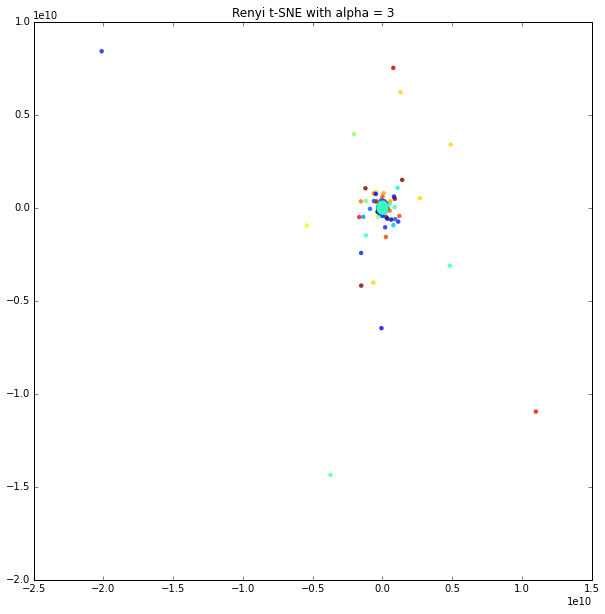

In [24]:
print "Run Y = tsne.tsne_renyi2_npca(X, alpha,  no_dims, perplexity) to perform t-SNE on your dataset."
print "Running COIL Dataset"

X = np.loadtxt('COIL-20_pca_50.txt')
labels = np.loadtxt('COIL-20_labels.txt')

#X = np.loadtxt('olivetti_pca_50.csv', delimiter = ',')

#alphas = [0.1, 0.2, 0.5, 0.7, 0.9, 0.95, 1.05, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6]
alphas = [3]
#alpha = 0.5
for alpha in alphas:
    max_iter = 50001
    Y = tsne_renyi2_npca(X, alpha = alpha, no_dims=2, max_iter= max_iter, eta= 0.01)
    #Y = tsne(X, 2, 30, 20.0, max_iter = 200)

    fname = 'COIL_renyi_2d_' + str(alpha) +  '_' + str(max_iter) + '.txt'
    np.savetxt(fname, Y)

    print "\a"    

    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    ax.scatter(Y[:,0], Y[:,1], 20, labels, edgecolor = 'none',  alpha = 0.8)
    ax.set_title('Renyi t-SNE with alpha = ' + str(alpha))
    plt.show()